# <center> FUNDAMENTOS DE APRENDIZAJE AUTOMÁTICO <br> Y RECONOCIMIENTO DE PATRONES</center>
## <center> Práctico 6, 2019 </center>      

In [3]:
# Se importan las bibliotecas que se utilizarán
import numpy as np
import glob
import matplotlib
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from scipy import signal
from scipy.io import wavfile

import IPython.display as ipd
from IPython.display import Image

import time
import os

%matplotlib inline

## Objetivos

- Plantear la **maximización del margen** en el algoritmo SVM y su resolución en el **espacio dual**.
- Formular las ventajas prácticas que puede presentar resolver el **problema dual**.
- Adquirir cierta intuición en cuanto a la solución brindada por el algoritmo SVM mediante su aplicación para **separar** entre distintos tipos de **sonidos** utilizando sólo dos características.
- Aplicar SVM en un problema de mediana escala para **clasificar** entre 10 categorías de **sonidos urbanos**.
- **Optimizar** los parámetros de un **clasificador SVM** utilizando la biblioteca *scikit-learn*.
- Aplicar correctamente el mecanismo de **validación cruzada** como forma de estimar la bondad del clasificador.
- Interpretar la información birndada por una matriz de confusión.

## Lista de ejercicios

[Ejercicio 1](#Ejercicio1): Formulación del algoritmo SVM       
[Ejercicio 2](#Ejercicio2): Separando sonidos con características intuitivas   
[Ejercicio 3](#Ejercicio3): SVM en un problema de mediana escala multiclase   
[Desafío](#Desafío): Urband Sound Challenge

<a id="Ejercicio1"></a>
## Ejercicio 1: Formulación del algoritmo SVM

El algoritmo $\textit{C-SVM}$ da lugar al siguiente problema de optimización:

\begin{align}\label{csvm} 
    \left\{ \begin{aligned}  
& \underset{\mathbf{w}, b, \mathbf{\xi}}{\min}
&  & f(\mathbf{w}, \mathbf{\xi}) = \frac{1}{2}||\mathbf{w}||^{2} + C \sum_{n=1}^{N} \xi_n \\
& \text{sujeto a} \\   
& & & y_n ( \mathbf{w}^T\Phi(x_n)  + b) \geq 1 - \xi_n \quad \forall n=1,\ldots,N\\  
& & & \xi_n \geq 0 \\   
   \end{aligned}   \right.  
\end{align} 

**Parte a)** Escribir el Lagrangiano $\mathcal{L}$ del problema. 

**Solución:**

$$
\mathcal{L}(w,b,\boldsymbol{\xi},\alpha,\beta) = \frac{1}{2}w^Tw + C\sum_{n=1}^N \boldsymbol{\xi}_n + 
                            \sum_{n=1}^N\alpha_n[1-\boldsymbol{\xi}_n-y_n(w^Tx_n + b)] + \sum_{n=1}^N \beta_n\boldsymbol{\xi}_n
$$
 

**Parte b)** Argumentar que el valor del Lagrangiano $\mathcal{L}$ está acotado superiormente por la función de costo original $f$. 

**Solución:**

?????

## El problema primal

**Parte c)** Se define la función $\theta_{\mathcal{P}}(\mathbf{w},b,\boldsymbol{\xi} )=\underset{\boldsymbol{\alpha}, \boldsymbol{\beta}; \alpha_n \geq 0, \beta_n \geq 0}{\max}\mathcal{L}(\mathbf{w},b,\boldsymbol{\xi}, \boldsymbol{\alpha}, \boldsymbol{\beta} ) $. Argumentar que resolver

$$
\underset{\mathbf{w}, b, \mathbf{\xi}}{\min} \theta_{\mathcal{P}}(\mathbf{w},b,\boldsymbol{\xi} )
$$

es equivalente a encontrar el mínimo de  $f(\mathbf{w}, \mathbf{\xi})$ con las restricciones del problema.

**Solución:** 

El problema de programación cuadrática:

\begin{align}\label{csvm} 
    \left\{ \begin{aligned}  
& \underset{ u \in \mathbb{R}^L }{\min}
&  & f(u) = \frac{1}{2}u^TQu + p^Tu \\
& \text{sujeto a} \\   
& & & a^Tu \geq \it{c} \\   
   \end{aligned}   \right.  
\end{align} 

es equivalente a resolver el siguiente problema de optimización (*):

$$
\underset{\mathbf{w}, b, \mathbf{\xi}}{\min}: \frac{1}{2}u^TQu + p^Tu + 
                                              \underset{\alpha \geq 0}{max}\alpha(\it{c}-a^Tu) 
$$

siempre y cuando exista al menos una solucion del problema QP original.

El Lagrangiano se define como:
$$
\mathcal{L}(u,\alpha) = \frac{1}{2}u^TQu + p^Tu + \alpha(\it{c}-a^Tu) 
$$

Entonces en términos de $\mathcal{L}$ el segundo problema pasa a ser:
$$
\underset{u}{min}\ \underset{\alpha \geq 0}{max}\mathcal{L}(u,\alpha)
$$

Llevando el problema a esta formulación se llega a lo que se quiere. 

Si se quiere llevar mas lejos, utilizando la relación de $\it{dualidad}$ $\it{fuerte}$:
$$
\underset{u}{min} \ \underset{\alpha \geq 0}{max}\mathcal{L}(u,\alpha) =
    \underset{\alpha \geq 0}{max} \ \underset{u}{min}\mathcal{L}(u,\alpha)
$$

se puede primero minimizar y luego maximizar.

(*) Si se pidiera demostrar la equivalencia tendría que resolver el ejercicio 8.9 del libro.

## El Problema Dual

 Se define ahora la función $\textit{dual}$ $\theta_{\mathcal{D}}(\boldsymbol{\alpha}, \boldsymbol{\beta} )=\underset{\mathbf{w},b,\boldsymbol{\xi}}{\min}\mathcal{L}(\mathbf{w},b,\boldsymbol{\xi}, \boldsymbol{\alpha}, \boldsymbol{\beta} ) $.      
En general se cumple para el óptimo del problema dual $d^*$ que

$$
d^* = \underset{\boldsymbol{\alpha}, \boldsymbol{\beta}}{\max} \theta_{\mathcal{D}}(\boldsymbol{\alpha}, \boldsymbol{\beta}) \leq  \underset{\mathbf{w}, b, \mathbf{\xi}}{\min} \theta_{\mathcal{P}}(\mathbf{w},b,\boldsymbol{\xi} ) = p^*
$$
 
Sin embargo, en el caso en que tanto la función a optimizar $f$ como sus restricciones son convexas se cumple que $d^*$ coincide con $p^*$. Este es el caso de SVM.

Desde el punto de vista práctico resolver el problema $\textit{primal}$ implica maximizar respecto a los multiplicadores de Lagrange primero y luego minimizar respecto a los pesos y las variables $\textit{slack}$. Resolver el problema $\textit{dual}$ en cambio implica minimizar respecto a los pesos y las variables $\textit{slack}$ primero y luego maximizar respecto a los multiplicadores.


**Parte d)** Mostrar que el problema dual puede escribirse como:
\begin{align*}
    \left\{ \begin{aligned}  
& \underset{\boldsymbol{\alpha}}{\min}
& & \frac{1}{2}\boldsymbol{\alpha}^{T}\boldsymbol{Q}\boldsymbol{\alpha} - \mathbb{1}^{T}\boldsymbol{\alpha} \\
& \text{sujeto a} \\
& & & 0 \leq \alpha_n \leq C \\ 
& & & \sum_n \alpha_n y_n = 0 \\ 
   \end{aligned}   \right. 
\end{align*}
con $Q_{ij} = y_i y_j K(x_i,x_j)$

**Solución**    
????

**Parte e)** Mencione por qué puede resultar más conveniente resolver el problema dual.

**Respuesta:**   
Debido a que en el problema dual uno resuelve primero con respecto a $u$ sin restricciones, lo cual se puede hacer de forma analítica.

<a id="Ejercicio2"></a>
## Ejercicio 2: Separando sonidos con características intuitivas

En los ejercicios 2 y 3 de este práctico se trabajará con la base de datos **Urban Sound**.

## Base de datos Urband Sound

La base de datos está conformada por una serie de fragmentos de audios en las que se escuchan sonidos característicos de un entorno urbano. En concreto, la base cuenta con sonidos pertenecientes a las siguientes 10 categorías:  
    
    0-  aire acondicionado  
    1-  bocina de auto  
    2-  niños jugando  
    3-  ladrido de perros  
    4-  taladrado  
    5-  motor moderando  
    6-  disparo de arma de fuego  
    7-  martillo neumático  
    8-  sirena  
    9-  música callejera  

Los fragmentos tienen una duración de 4 segundos. Los fragmentos fueron extraídos de grabaciones más grandes utilizando ventanas de 4 segundos solapadas entre sí por 2 segundos.  

Los datos se provén separados en 10 *folds*, tomando en cuenta que en *folds* distintos NO existen extractos de un mismo audio.  

### Distribución de la base de datos

La siguiente celda lee la *metadata* de la base de datos y genera un gráfico que muestra la distribución de las clases según los *folds* y la cantidad de audios por clase.

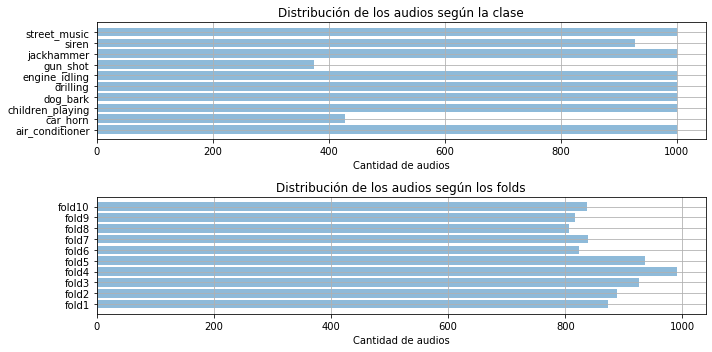

In [4]:
# función auxiliar
def split_data(all_data):
    '''
    Separa los datos en 10 Folds predefinidos
    '''
    folders = [[], [], [], [], [], [], [], [], [], []]
    for ln in range(len(all_data)):
        folders[int(all_data[ln][5]) - 1].append(all_data[ln])
    for ln in range(len(folders)):
        folders[ln] = np.array(folders[ln])
    return np.array(folders)


file_metadata_path = 'dataset/metadata'
metadata = []

with open(os.path.join(file_metadata_path, 'UrbanSound8K.csv'), 'r') as file_metadata:
    line1 = file_metadata.readline()
    metadata.append(line1.split('\n')[0].split(','))
    for line in file_metadata:
        metadata.append(line.split('\n')[0].split(','))
        metadata[-1][5] = metadata[-1][5].zfill(2)

headers = metadata[0]
all_data = np.array(metadata[1:])

folders = split_data(all_data)

uniqueValues, occurCount = np.unique(all_data[:, 6], return_counts=True)
objects = ('air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 
           'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 
           'street_music')
y_pos = np.arange(len(objects))
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.barh(y_pos, occurCount, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Cantidad de audios')
plt.title('Distribución de los audios según la clase')
plt.grid()

plt.subplot(2,1,2)
_, occurCount2 = np.unique(all_data[:, 5], return_counts=True)
objects2 = ('fold1', 'fold2', 'fold3', 'fold4', 'fold5', 
            'fold6', 'fold7', 'fold8', 'fold9', 'fold10')
y_pos2 = np.arange(len(objects2))
plt.barh(y_pos, occurCount2, align='center', alpha=0.5)
plt.yticks(y_pos2, objects2)
plt.xlabel('Cantidad de audios')
plt.title('Distribución de los audios según los folds')
plt.grid()
plt.tight_layout()

## Descripción del ejercicio

Dadas tres clases de sonidos urbanos pertenecientes a un fold:

    - Tomar dos clases linealmente separables mediante la extracción de dos características.
    - Encontrar la recta de decisión mediante regresión logística
    - Encontrar la recta de decisión mediante el clasificador svm con parámetros por defecto
    - Calcular la cantidad de vectores soporte y el tamaño del margen.
    - Plotear los resultados
    - Cambiar el parámetro C de svm y observar cambios.
    - Para las tres clases clasificar utilizando un kernel no lineal, hallar vectores soporte y plotear resultados.

## Características

En el presente ejercicio se trabajará con dos características de la señal en el tiempo con el fin de mostrar que existen señales que no requieren de características complejas para poder clasificarlas.

Las características son las siguientes:

    - ZCR (Zero-Crossing-Rate): la cantidad de cruces por cero de las muestras de la señal.
    
    - RMS (root-mean-square): la raíz del valor cuadrático medio de las muestras de la señal, también conocida como medida de la energía de la señal.
    
$$ x_{RMS} = \sqrt{\frac{1}{N}\sum_{i=1}^{N}x_{i}^2} $$

Se utilizarán las siguientes 3 clases de sonidos pertenecientes al fold 3:

    5-  motor moderando  
    6-  disparo de arma de fuego  
    7-  martillo neumático
    


La distribución de los fragmentos por clase en el *fold* es la siguiente:

    - motor moderando = 107 fragmentos
    - disparo de arma de fuego = 36 fragmentos
    - martillo neumático = 120 fragmentos
    
Como se mencionó anteriormente, en un mismo *fold* hay varios audios que son fragmentos de una misma grabación original. La distribución por grabación es la siguiente:

    - motor moderando = 10 grabaciones
    - disparo de arma de fuego = 12 grabaciones
    - martillo neumático = 5 grabaciones

Funciones auxiliares para plotear las señales de los audios 

In [5]:
# ejecutar y seguir
def plot_una_clase(path_audios, clase):
    cont = 0
    tam = len(glob.glob(os.path.join(path_audios, clase, '*.npy')))
    fig, axes = plt.subplots(tam, 1, figsize=(10, 10))
    for path_au in glob.glob(os.path.join(path_audios, clase, '*.npy')):
        y = np.load(path_au)
        axes[cont].plot(np.arange(len(y)), y)
        axes[cont].grid()
        axes[cont].axis([0, len(y), -1.2, 1.2])
        cont += 1   
    axes[0].set_title('clase ' + clase)
    fig.tight_layout()
        
def plot_comparar_dos_clases(path_audios, clases):
    tam_clas_mayor = np.max([len(glob.glob(os.path.join(path_audios, clases[0], '*.npy'))), 
                            len(glob.glob(os.path.join(path_audios, clases[1], '*.npy')))])
    fig, axes = plt.subplots(nrows=tam_clas_mayor, ncols=2, figsize=(15, 10))
    for clase in clases:
        cont = 0
        for path_au in glob.glob(os.path.join(path_audios, clase, '*.npy')):
            y = np.load(path_au)
            if clase == clases[0]:
                axes[cont, 0].plot(np.arange(len(y)), y)
                axes[cont, 0].grid()
                axes[cont, 0].axis([0, len(y), -1.2, 1.2])
            else:
                axes[cont, 1].plot(np.arange(len(y)), y)
                axes[cont, 1].grid()
                axes[cont, 1].axis([0, len(y), -1.2, 1.2])
            cont += 1
        if clase == clases[0]:
            axes[0, 0].set_title('clase ' + clase)
        else:
            axes[0, 1].set_title('clase ' + clase)
    fig.tight_layout()

En el siguiente código se pueden plotear las señales de los audios representativos de las clases y las características:

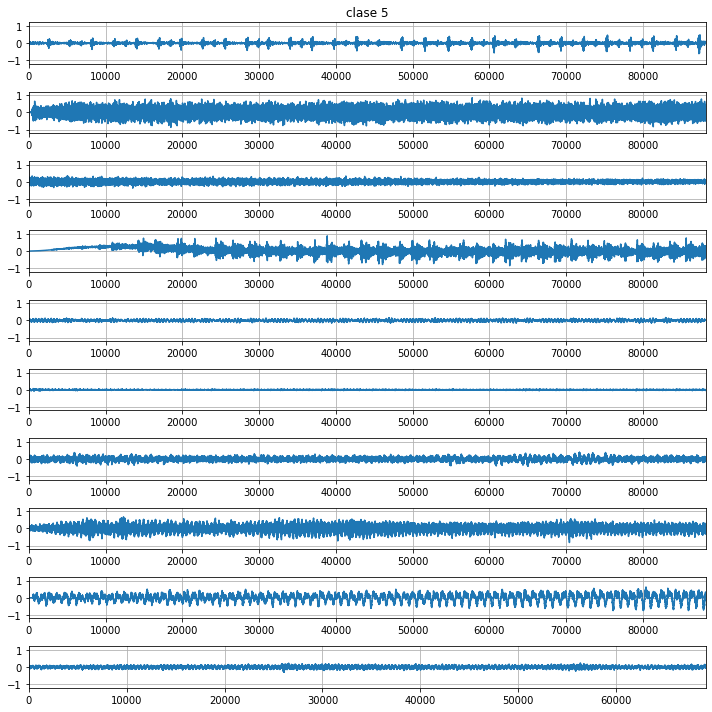

In [6]:
path_audios = 'dataset/audios/fold3'
clases = ['5', '6', '7']
plot_una_clase(path_audios, clases[0])

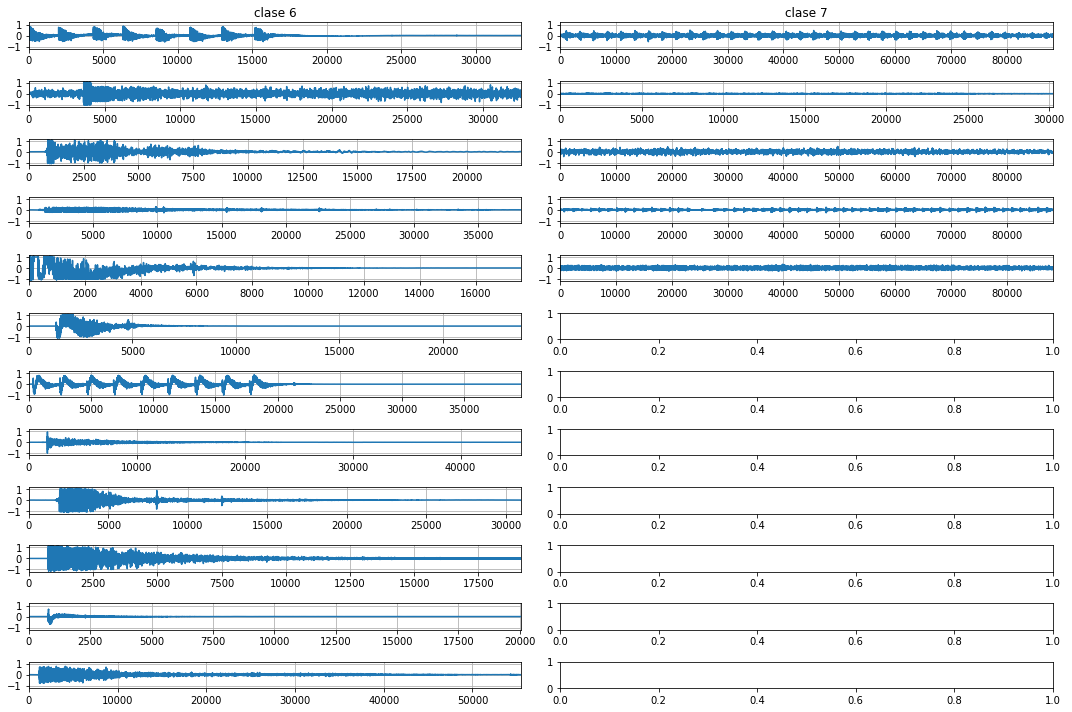

In [7]:
plot_comparar_dos_clases(path_audios, clases[1:])

Funciones necesarias para extraer y plotear las características:

In [8]:
def features_from_arrays(features_from_fold, tipo_c1='', tipo_c2=''):
    '''
    Entrada:
        features_from_fold: características calculadas en el fold
        tipo_c1: string que puede ser mean, min, max, std o vacio para calcular el ZCR
        tipo_c2: string que puede ser mean, min, max, std o vacio para calcular el RMS

    Salida:
        numpy array con dos caractersísticas:
            ZCR: ratio de cruces por cero, en el caso de tener entrada vacia se devuelve el array entero
            RMS: raíz del error cuadrático medio, en el caso de tener entrada vacia se devuelve el array entero
    '''
    for i in range(len(features_from_fold)):
        if tipo_c1 == 'mean':
            features_from_fold[i][0] = np.mean(features_from_fold[i][0])
        elif tipo_c1 == 'min':
            features_from_fold[i][0] = np.min(features_from_fold[i][0])
        elif tipo_c1 == 'max':
            features_from_fold[i][0] = np.max(features_from_fold[i][0])
        elif tipo_c1 == 'std':
            features_from_fold[i][0] = np.std(features_from_fold[i][0])

        if tipo_c2 == 'mean':
            features_from_fold[i][1] = np.mean(features_from_fold[i][1])
        elif tipo_c2 == 'min':
            features_from_fold[i][1] = np.min(features_from_fold[i][1])
        elif tipo_c2 == 'max':
            features_from_fold[i][1] = np.max(features_from_fold[i][1])
        elif tipo_c2 == 'std':
            features_from_fold[i][1] = np.std(features_from_fold[i][1])

    return features_from_fold

def plot_features_2clases(class_features, c1, c2, op_type1_1, op_type2_1):
    xtrain = np.vstack([class_features[c1], class_features[c2]])
    scaler = StandardScaler()
    scaler.fit(xtrain)
    xtrain = scaler.transform(xtrain)
    lab = np.hstack([np.zeros(len(class_features[c1])), np.ones(len(class_features[c2]))])
    
    plt.figure()
    plt.scatter(xtrain[:len(class_features[c1]), 0], xtrain[:len(class_features[c1]), 1], label=objects[c1])
    plt.scatter(xtrain[len(class_features[c1]):, 0], xtrain[len(class_features[c1]):, 1], label=objects[c2])
    plt.grid()
    plt.legend()
    plt.xlabel('ZCR ' + op_type1_1)
    plt.ylabel('RMS ' + op_type2_1)

La extracción de características se realiza con el siguiente código:

In [9]:
# se levantan las características (ZCR, RMS) calculadas los audios de cada fold
folders_features = np.load('dataset/linealfeat_all_folds.npy', allow_pickle=True) # objeto python de largo 10

fold = 3
c1 = 6
c2 = 7

op_type1_1 = 'mean'
op_type2_1 = 'std'


class_features = []
for i in range(10):
    fi = folders_features[fold-1][folders[fold-1][:, -2] == np.str(i)]
    fi = features_from_arrays(fi, tipo_c1=op_type1_1, tipo_c2=op_type2_1)
    class_features.append(fi)
# class_features es una lista de largo 10 (número de clases) que almacena las características 
# calculadas para cada clase en el fold indicado    
class_features = np.array(class_features)

Se muestra la distribución de características de las dos clases seleccionadas (*c1* y *c2*)

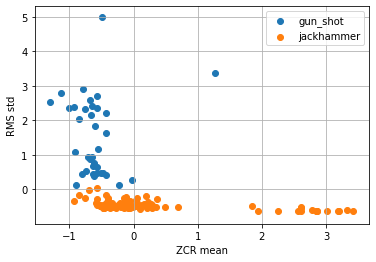

In [10]:
plot_features_2clases(class_features, c1, c2, op_type1_1, op_type2_1)

**Pregunta:** ¿Le parece razonable la distribución de los puntos para el caso del disparo y el martillo neumático? ¿Qué comportamiento de la señal logran capturar las características elegidas?

**Respuesta:**
Que significa que la media de ZCR sea negativa??

Preguntar para interpretar mejor esto pq no estaria saliendo

## Clasificación 

En esta parte se compararán las soluciones de *Regresión Logística* y *SVM*. En el caso de SVM se trabajará con un *kernel linear*.

In [11]:
# función auxiliar para mostrar el resultado de la clasificación
def plot_clasificadores(class_features, clf_svm, clf_logreg, c1, c2, op_type1_1, op_type2_1):
    
    plt.figure(figsize=(10,10))
    plt.scatter(xtrain[:len(class_features[c1]), 0], xtrain[:len(class_features[c1]), 1], label=objects[c1])
    plt.scatter(xtrain[len(class_features[c1]):, 0], xtrain[len(class_features[c1]):, 1], label=objects[c2])

    # plot the decision svm
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf_svm.decision_function(xy).reshape(XX.shape)
    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf_svm.support_vectors_[:, 0], clf_svm.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k', label='vectores de soporte')

    # plot regresión logística
    w_log = clf_logreg.coef_[0]
    b_log = clf_logreg.intercept_[0]
    ap = -w_log[0] / w_log[1]
    ymin = xtrain[:, 1].min()
    ymax = xtrain[:, 1].max()
    if ap >= 0:
        xmin = np.max([(ymin + b_log / w_log[1]) / ap, xtrain[:, 0].min()])
        xmax = np.min([(ymax + b_log / w_log[1]) / ap, xtrain[:, 0].max()])
    else:
        xmin = np.max([(ymax + b_log / w_log[1]) / ap, xtrain[:, 0].min()])
        xmax = np.min([(ymin + b_log / w_log[1]) / ap, xtrain[:, 0].max()])
    xx = np.linspace(xmin, xmax)
    yy = ap * xx - b_log / w_log[1]
    plt.plot(xx, yy, 'r-', label='límite de decisión de regresión logística')
    
    plt.legend()
    plt.xlabel('ZCR ' + op_type1_1)
    plt.ylabel('RMS ' + op_type2_1)
    plt.grid()
    plt.show()


La siguiente celda genera un conjunto de entrenamiento conformado únicamente por las clases elegidas. 

In [12]:
# Se genera un conjunto de entrenamiento conformado únicamente por las clases elegidas
xtrain = np.vstack([class_features[c1], class_features[c2]])
lab = np.hstack([np.zeros(len(class_features[c1])), np.ones(len(class_features[c2]))])

**Ejercicio:** Comparar las soluciones brindadas por *Regresión Logística* y *SVM*.    

In [ ]:
#################################################################################################################
########################  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################################
#################################################################################################################

# Se define el clasificador
log_clf = LogisticRegression(solver='sag', max_iter=10000)

# Se encuentran los parámetros
log_clf.fit(feat_train_n,  y_train.flatten())

# Se predicen los valores de las muestras de entrenamiento y test
y_pred_train = log_clf.predict(feat_train_n)
y_pred_test = log_clf.predict(feat_test_n)

# Se calcula el desempeño para los conjuntos de entrenamiento y test
print("Accuracy con conjunto de entrenamiento: %f" % log_clf.score(feat_train_n, y_train.flatten()))
print("Accuracy con conjunto de test: %f" % log_clf.score(feat_test_n, y_test))

# Se muestran los parámetros aprendidos
W_log = log_clf.coef_
mostrar_pesos(W_log)

######################################
######################################

# Se estandarizan o no las características
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(xtrain)

# Se entrena el clasificador de regresión logística 
clf_logreg = LogisticRegression(solver='sag', max_iter=10000)

# Se encuentran los parámetros
clf_logreg.fit(xtrain,  y_train.flatten())

clf_logreg = 


# Se entrena el clasificador svm con kernel linear
# clf_svm = 


# se obtiene el número de vectores de soporte del clasificador 
# num_vec_sop = 

# se obtiene el tamaño del margen
# tam_margen =

#################################################################################################################
########################  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################################
#################################################################################################################

print('El clasificador SVM tiene {} vectores soporte.'.format(num_vec_sop))
print('El tamaño del márgen es {}'.format(tam_margen))
# Se muestra el resultado de los clasificadores entrenados anteriormente
plot_clasificadores(class_features, clf_svm, clf_logreg, c1, c2, op_type1_1, op_type2_1)

**Ejercicio:** ¿Cómo varía el número de soportes en función de $C$? ¿Y el margen? Puede ser útil crear una nueva celda y generar una gráfica que muestre la variación de estas cantidades con $C$.

**Respuesta:**  
... 

**Pregunta:** Nombre algún par de clases que considere que son fáciles de separar  y al menos un par que considere difíciles con estas características.

**Respuesta:** 
...

## Clasificación SVM multiclase

En esta parte se utilizará SVM para clasificar entre tres clases pertenecientes a un mismo *fold*.

Función para mostrar el resultado de la clasificación

In [ ]:
def plot_svm_multiclase(X, Y, clf, op_type1_1, op_type2_1):
    
    plt.figure(figsize=(10,10))
    # plot the decision
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = .01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, alpha=.1)
#     # plot support vectors
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k', label='support vectors')

#     plt.legend()
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolors='k')
    plt.xlabel('ZCR ' + op_type1_1)
    plt.ylabel('RMS ' + op_type2_1)
    plt.grid()
    plt.show()

In [ ]:
# Se define el fold y las clases a separar
fold = 3
c1 = 5
c2 = 6
c3 = 7

# Se calculan las características
op_type1_1 = 'mean'
op_type2_1 = 'std'

class_features = []
for i in range(10):
    fi = folders_features[fold-1][folders[fold-1][:, -2] == np.str(i)]
    fi = features_from_arrays(fi, tipo_c1=op_type1_1, tipo_c2=op_type2_1)
    class_features.append(fi)
class_features = np.array(class_features)

Se arma el conjunto de entrenamiento con las clases elegidas

In [ ]:
xtrain = np.vstack([class_features[c1], class_features[c2], class_features[c3]])
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
lab = np.hstack([np.zeros(len(class_features[c1])), np.ones(len(class_features[c2])), np.ones(len(class_features[c3]))*2])

**Ejercicio:** Entrenar un clasificador SVM que logre separar correctamente todo el conjunto de entrenamiento. 

In [ ]:
####################################################################################################################
###########################  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  ################################################
####################################################################################################################


# clf_svm =

# num_vec_sop = 

# E_in = 

####################################################################################################################
###########################  TERMINA ESPACIO PARA COMPLETAR CODIGO  ################################################
####################################################################################################################
plot_svm_multiclase(xtrain, lab, clf_svm, op_type1_1, op_type2_1)
print('El clasificador SVM tiene {}/{} vectores soporte.'.format(num_vec_sop, len(xtrain)))

**Pregunta:** ¿Cuál es el criterio que usa la implementación SVC para clasificar múltiples clases?

**Respuesta:**  
...

**Pregunta:** ¿Y en el caso de Regresión Logística? ¿Cómo se lleva a cabo la clasificación multiclase?

**Respuesta:**  
...

<a id="Ejercicio3"></a>
# Ejercicio 3: SVM en un problema de mediana escala multiclase

### Descripción del ejercicio

En este ejercicio se utilizará un clasificador SVM para separar los sonidos  urbanos de la base de datos *Urband Sound*. Se dividirán los *folds* en conjuntos de entrenamiento, validación y test. Los primeros 6 folds conformarán el conjunto de entrenamiento, los folds 7-8 el de validación y los folds 9-10 el de test.

### Características

Se utilizarán las mismas características que en el *paper* [A Dataset and Taxonomy for Urban Sound Research](http://www.justinsalamon.com/uploads/4/3/9/4/4394963/salamon_urbansound_acmmm14.pdf) que es el trabajo que presentó la base de datos. 

#### Coeficientes Cepstrales de Frecuencia Mel (MFCC)

Los Coeficientes Cepstrales de Frecuencia Mel (MFCC) son características que representan propiedades del espectro de tiempo corto de una señal de audio. En particular, permiten capturar la evolución de la envolvente espectral, lo que es de especial relevancia para discriminar el tipo de sonido. Por esta razón, son muy utilizados para el procesamiento y análisis de señales de voz, sonidos ambientales y música.


El cálculo de los MFCC se representa en el esquema de la siguiente figura. La señal de entrada $x[n]$ es dividida en tramas temporales solapadas, mediante una ventana suavizante $w[n]$ y se calcula la magnitud del espectro de cada trama $|X[k]|$ usando la DFT. La magnitud del espectro pasa por un banco de filtros que sigue aproximadamente la respuesta en frecuencia de la percepción auditiva humana. Los componentes de frecuencia que pasan por cada filtro del banco $V_l[k]$ son ponderados por la respuesta del filtro y se suma su magnitud al cuadrado, lo que corresponde a un cálculo de energía. Luego se calcula el logaritmo de la señal de salida y se convierte al dominio del tiempo usando la Transformada de Coseno Discreto (DCT). Además de volver al dominio del tiempo, la DCT descompone los coeficientes de forma de que cada coeficiente tiene información diferente a la de los demás coeficientes. Es habitual conservar solo los primeros coeficientes de la DCT, los cuales se relacionan con la envolvente espectral de la señal. Para capturar la evolución temporal de los MFCC se suele calcular además la derivada de primer y segundo orden de cada coeficiente.  

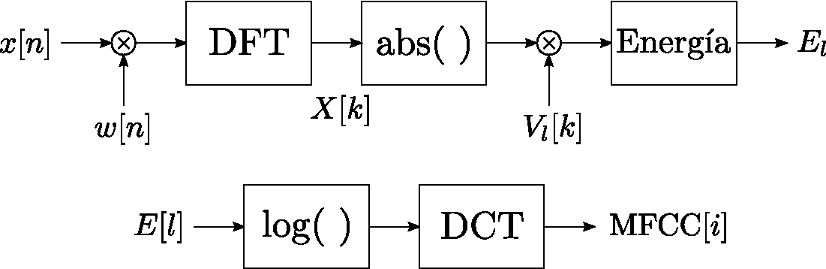

In [3]:
Image(filename="figuras/mfcc_bloques.png")

Para el cálculo de los MFCC que se usarán a continuación, se segmenta la señal de audio en tramas de tamaño 23,2 ms con un 50% de solapamiento entre tramas y se aplica un banco de filtros con 40 bandas Mel distribuidas entre 0 y 22050 Hz. A la salida de la DCT se conservan los primeros 25 coeficientes MFCC. Luego, el comportamiento de cada coeficiente MFCC a lo largo de todas las tramas de un archivo de audio se describe calculando las siguientes características: mínimo, máximo, mediana, media, varianza,  asimetría, kurtosis y la media y varianza de la primera y segunda derivadas de la señal, resultando en un vector de características de dimensión 275.

A continuación se muestran los primeros 12 MFCC calculados para los dos archivos de ejemplo.

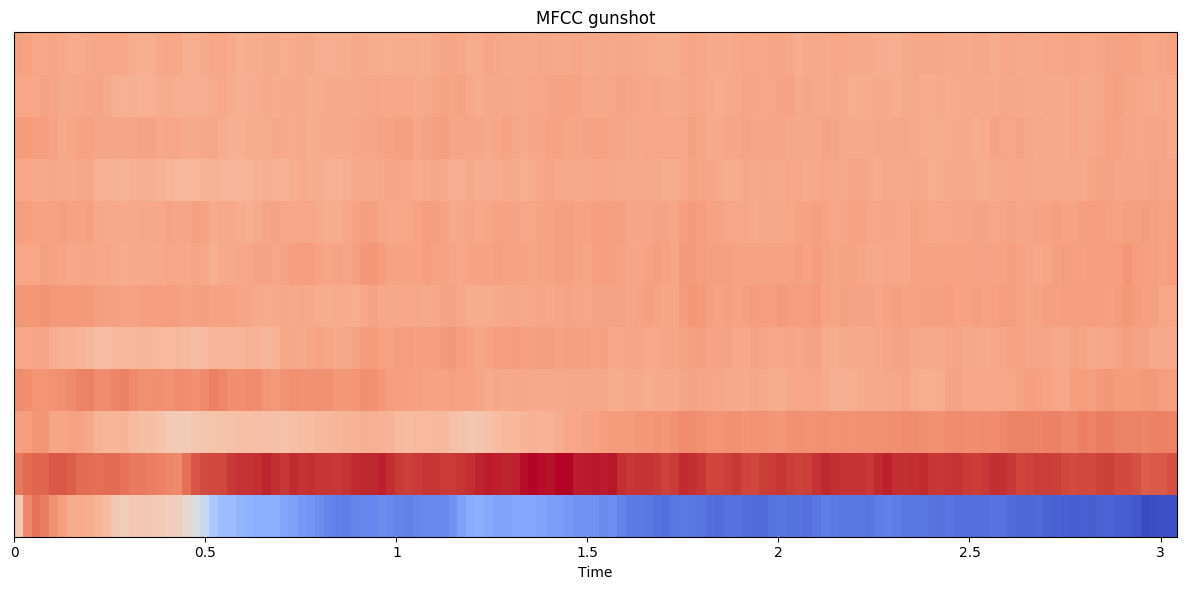

In [4]:
Image(filename="figuras/gunshot.png")

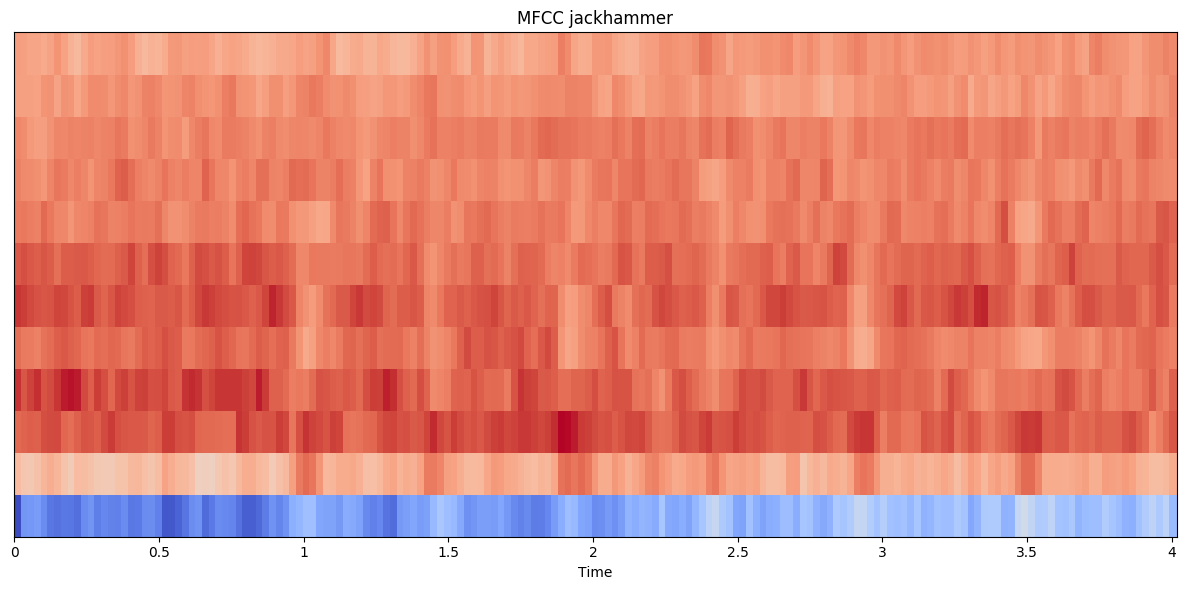

In [5]:
Image(filename="figuras/jackhammer.png")

Dado que la extracción de características lleva un tiempo no despreciable, las mismas fueron precalculadas. A continuación se levantan las mismas desde el directorio *dataset*.  

In [6]:
def extraer_caracteristicas(folds_list):
    '''
    Función que parsea los folds para generar conjuntos de entrenamiento/validación/test
    Entrada:
        folds_list: lista que contiene los folds que se quieren utilizar 
                    para construir el conjunto
    Salida:
        features: arreglo de tamaño (N, 275) que contiene las características extraídas 
                  de los folds
        labels: vector de tamaño (N,) que contiene las clases a la que pertenecen
                las muestras
        fold_indices: vector de tamaño (N,) que contiene a que fold pertenece la muestra
    '''
    data_list = []  # lista auxiliar que contiene los folds
    indices_list = []  # lista auxiliar que contiene los indices de los folds
    for foldNumber in folds_list:
        filename = 'dataset/' + "features_fold_" + str(foldNumber) + ".csv"
        data = np.loadtxt(filename, delimiter=',', skiprows=1)  # se lee un fold
        indices = foldNumber * np.ones(data.shape[0])  # se asocia un número de fold a cada dato
        data_list.append(data)  # se agrega la data del fold a la lista
        indices_list.append(indices)  # se agregan los indices a la lista de indices
    data = np.concatenate(data_list)
    fold_indices = np.concatenate(indices_list)
    features = data[:, :275]
    labels = data[:, 276]
    return features, labels, fold_indices

Se divide el conjunto de datos en *entrenamiento* y *validación*

In [ ]:
# Se construye el conjunto de entrenamiento con los primeros seis folds
features_train, labels_train, fold_indices_train = extraer_caracteristicas([1,2,3,4,5,6])
print('El conjunto de entrenamiento cuenta con %d audios' % len(features_train))
# Se construye el conjunto de validación con los folds 7 y 8
features_val, labels_val, fold_indices_val = extraer_caracteristicas([7, 8])
print('El conjunto de validación cuenta con %d audios' % len(features_val))
# Los folds 9 y 10 se utilizarán para test. No se provén las etiquetas del conjunto de test
features_test, labels_test, _ = extraer_caracteristicas([9, 10])
print('El conjunto de test cuenta con %d audios' % len(features_test))

## Parte 1: clasificador por defecto

Entrenar el clasificador SVM con parámetros por defecto utilizando el conjunto de entrenamiento. 

In [ ]:
################################################################################
##########  EMPIEZA ESPACIO PARA COMPLETAR CODIGO  #############################
################################################################################

# clf_svm =

# E_in = 

# E_val = 

################################################################################
##########  TERMINA ESPACIO PARA COMPLETAR CODIGO  #############################
################################################################################

**Pregunta:** Describa el punto de funcionamiento del clasificador

**Respuesta:** 

**Pregunta:** ¿Cuál es el número de vectores de soporte? ¿Es útil dicha información?

**Respuesta:** 

## Parte 2:  anticipando el comportamiento en validación

En ciertas oportunidades es deseable estimar el desempeño del *conjunto de validación* con el *conjunto de entrenamiento* para no contaminar los mismos innecesariamente. Una forma habitual es hacer *validación cruzada* con el conjunto de entrenamiento.  

A continuación se hará validación cruzada con el conjunto de entrenamiento. Para ello se utilizará la función `cross_validate()` del paquete *model selection*. Lo haremos de tres formas diferentes.

In [ ]:
# validación cruzada 6-fold con cv=6
scores = cross_validate(clf_svm, features_train, labels_train, return_train_score=True, cv=6)
print('Accuracy con conjunto de entrenamiento = %f' % scores['train_score'].mean())
print('Accuracy con conjunto de validación = %f' % scores['test_score'].mean())

In [ ]:
# validación cruzada 6-fold utilizando cv = ShuffleSplit
cv = ShuffleSplit(n_splits=6, test_size=1/6, random_state=0)
scores = cross_validate(clf_svm, features_train, labels_train, return_train_score=True, cv=cv)
print('Accuracy con conjunto de entrenamiento = %f' % scores['train_score'].mean())
print('Accuracy con conjunto de validación = %f' % scores['test_score'].mean())

In [ ]:
# validación cruzada 6-fold utilizando cv = PredefinedSplit
cv = PredefinedSplit(test_fold=fold_indices_train)
scores = cross_validate(clf_svm, features_train, labels_train, return_train_score=True, cv=cv)
print('Ein-cv2 = {}'.format(scores['train_score'].mean()))
print('Ecv2 = {}'.format(scores['test_score'].mean()))

**Pregunta:** Explique brevemente en qué consiste la validación cruzada y en qué difieren las tres formas de realizarlo que se implementaron. 

**Respuesta:** 
...

**Pregunta:** ¿Cuál de las tres estrategias de validación cruzada implementadas le parece más apropiada para este problema? ¿Es la que predice mejor los resultados con el conjunto de validación? 

**Respuesta:** ...

## Parte 3: Eligiendo los parámetros del clasificador SVM

A continuación se mostrará una forma de elegir los parámetros óptimos del clasificador para el caso de utilizar un *kernel linear* y un *kernel rbf*

### Eligiendo C  para el kernel lineal con GridSearch

In [ ]:
# Se define un vector con los valores de C a probar
# En una primera pasada se suele utilizar una grilla logarítmica
Cs = np.logspace(-5, 0, 6)

# Se define el diccionario con los parámetros a probar, en este caso solo C
param_grid= {'C' : Cs}

# Se realiza la división del conjunto de entrenamiento en los 6 folds
cv = PredefinedSplit(test_fold=fold_indices_train)

# Se define la validación cruzada a realizar para el kernel lineal
grid = GridSearchCV(svm.SVC(kernel='linear'), param_grid=param_grid, 
                    cv=cv, verbose=3, n_jobs=-1)

# Se realiza la búsqueda de parámetros
grid.fit(features_train, labels_train)

print("Los mejores parámetros fueron %s con un accuracy de %0.3f"
      % (grid.best_params_, grid.best_score_))

In [ ]:
# Se guarda el mejor clasificador encontrado 
best_clf_linear = grid.best_estimator_

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(np.log10(Cs), grid.cv_results_['mean_test_score'],'*-')
plt.title('Resultados de la validación cruzada para kernel lineal')
plt.xlabel('Valores de C (10^)')
plt.ylabel('Accuracy')

## Eligiendo C y Gamma para el kernel RBF con GridSearch

In [ ]:
# función auxiliar que muestra los parámetros del gridsearch
def mostrar_grid_search_results(rangoC, rangoGamma, resultados):
    '''
    Entrada:
        rangoC: lista con los valores de C evaluados
        rangoGamma: lista con los valores de gamma evaluados
        resultados: arrglo de tamaño (len(rangoC),len(rangoGamma)) con los resultados
                    del grid-search
    '''
    fig, ax = plt.subplots()
    im = ax.imshow(resultados, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set_ylabel('C')
    ax.set_ylim(-0.5,len(rangoC)-0.5)
    ax.set_xlim(-0.5,len(rangoGamma)-0.5)
    ax.set_yticks(range(len(rangoC)))
    ax.set_xticks(range(len(rangoGamma)))
    rangoC_labels = [str(c) for c in rangoC]
    ax.set_yticklabels(rangoC_labels)
    ax.set_xlabel('Gamma')
    rangoGamma_labels = [str(gamma) for gamma in rangoGamma]
    ax.set_xticklabels(rangoGamma_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                    rotation_mode="anchor")
    plt.title('Resultados del Grid Search')

**Ejercicio:** Realizar la búsqueda de parámetros óptimos para la grilla de valores de $C$ y $\gamma$ que se indica a continuación.

In [ ]:
# Se construye la grilla para hacer el grid-search
# Es habitual usar una grilla logarítmica en base 10 en una primera
# pasada y luego refinarla con una búsqueda lineal o en base 2 (mas costoso)

Cs = np.logspace(-2, 7, 4)  
gammas = np.logspace(-9, -3, 5)

####################################################################################################################
#################   EMPIEZA ESPACIO PARA COMPLETAR CODIGO  #########################################################
####################################################################################################################






####################################################################################################################
#################   TERMINA ESPACIO PARA COMPLETAR CODIGO  #########################################################
####################################################################################################################



**Pregunta:** ¿Cuáles fueron los parámetros óptimos de $C$ y $\gamma$ para la grilla sugerida?

**Respuesta:**

Una vez realizada la búsqueda se muestran los valores óptimos. Además se puede acceder a información detallada de la búsqueda a través de los atributos del objeto *GridSearchCV*.  

In [ ]:
# El mejor clasificador encontrado 
best_clf_rbf = grid.best_estimator_
# Detalle de la validación cruzada a través del diccionario cv_results_
print('Claves del diccionario que almacena los resultados:')
print(grid.cv_results_.keys())

In [ ]:
# Se muestran los resultados del grid-search
resultados = grid.cv_results_['mean_test_score']
resultados = resultados.reshape(len(Cs),len(gammas))
print(resultados)
mostrar_grid_search_results(Cs, gammas, resultados)

## Evaluación de los mejores clasificadores con el conjunto de validación

In [ ]:
acc_val_linear = best_clf_linear.score(features_val, labels_val)
print('El accuracy con el conjunto de validación utilizando kernel linear es: % .03f' % acc_val_linear)
acc_val_rbf = best_clf_rbf.score(features_val, labels_val)
print('El accuracy con el conjunto de validación utilizando kernel rbf es: % .03f' % acc_val_rbf)

**Pregunta:** Si tuviera que entregar el clasificador en este momento ¿Cuál entregaría?

A continuación se muestra la matriz de confusión con el conjunto de validación. 

In [ ]:
# funcion auxiliar (Ejecutar y seguir)
def mostrar_matriz_confusion(cm, target_names,
                            normalize=False,
                            cmap=plt.cm.Blues):
    '''
    Muestra la matriz de confusión
    '''

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            xticklabels=target_names, yticklabels=target_names,
            title= 'Matriz de confusion normalizada' if normalize else 'Matriz de confusion sin normalizar',
            ylabel='Etiqueta',
            xlabel='Predicción',
            xlim=(-0.5,9.5),
            ylim=(9.5,-0.5))

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

In [ ]:
cm

In [ ]:
# Matriz de confusión utilizando kernel linear
y_pred = best_clf_linear.predict(features_val)
clases = ('air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 
           'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 
           'street_music')
cm = confusion_matrix(labels_val, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
mostrar_matriz_confusion(cm_normalized, clases, normalize=True)

In [ ]:
# Matriz de confusión utilizando kernel rbf
y_pred = best_clf_rbf.predict(features_val)
clases = ('air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 
           'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 
           'street_music')
cm = confusion_matrix(labels_val, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
mostrar_matriz_confusion(cm_normalized, clases, normalize=True)

## Mejorando el clasificador SVM

Un primer objetivo es el de mejorar los clasificadores SVM base ya entrenados. Algunas posibilidades que se pueden explorar a dichos efectos son:
- Refinar la grilla de búsqueda de parámetros óptimos 
- Explorar la utilización de otro kernel
- Evaluar el impacto de aplicar algún preprocesamiento de características

In [ ]:
# Construyendo un buen clasificador svm ...

<a id="Desafio"></a>
## Desafío: Urband Sound Challenge

Su misión, si desea aceptarla, es generar el mejor clasificador posible para los sonidos urbanos de los *folds* 9 y 10. Para ello deberá en primer lugar formar un equipo de dos personas ya que no se considerarán como parte del desafío entregas individuales.

Como clasificador se podrá utilizar cualquiera de los algoritmos vistos en el curso (perceptrón, regresión lineal, regresión logística, redes neuronales o svm). Además, se podrá utilizar una combinación de varios clasificadores. En caso de que los clasificadores tengan rendimientos diferentes para las distintas clases se podrá, por ejemplo, elegir tres clasificadores y combinarlos mediante el voto de la mayoría.  

In [ ]:
# Construyendo un buen clasificador ...

En unos días se habilitará una tarea en el eva para subir las predicciones realizadas sobre el conjunto de test. 